In [69]:
import os
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, matthews_corrcoef

In [47]:
data = pd.read_csv('../out_files/alphafold/featurevector_alphafold.txt', sep='\t', low_memory=False)
data

,prot_uniprotAcc,wt_residue,mut_residue,position,meta_merged,composition,polarity,volume,granthamScore,domains_all,...,region_dist,signalPeptide_dist,modifiedResidue_dist,zincFinger_dist,motif_dist,coiledCoil_dist,peptide_dist,transitPeptide_dist,glycosylation_dist,propeptide_dist
0,O00299,C,S,24,O00299C24S,1.33,-3.7,23.0,112,IPR002946,...,0.0,[],0.0,[],hit,[],[],[],[],[]
1,O60260,C,S,431,O60260C431S,1.33,-3.7,23.0,112,IPR002867,...,0.0,[],15.7,0.0,[],[],[],[],[],[]
2,P18031,C,S,215,P18031C215S,1.33,-3.7,23.0,112,IPR000242,...,40.81,[],0.0,[],[],[],[],[],[],[]
3,P01009,M,V,382,P01009M382V,0.00,-0.2,21.0,21,IPR000215,...,0.0,46.22,3.87,[],[],[],0.0,[],32.56,[]
4,P27695,H,N,309,P27695H309N,-0.75,-1.2,40.0,68,IPR004808,...,0.0,[],3.83,[],5.85,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262,P08686,C,S,428,P08686C428S,1.33,-3.7,23.0,112,IPR001128,...,[],[],[],[],[],[],[],[],[],[]
8263,P08686,C,T,428,P08686C428T,2.04,-3.1,-6.0,149,IPR001128,...,[],[],[],[],[],[],[],[],[],[]
8264,Q6P587,E,A,33,Q6P587E33A,0.92,4.2,52.0,107,IPR011234,...,[],[],10.74,[],[],[],[],13.23,[],[]
8265,O75319,N,A,204,O75319N204A,1.33,3.5,25.0,111,IPR000340,...,54.06,[],[],[],[],[],[],[],[],[]


In [48]:
data.replace('[]', np.nan, inplace=True)
data.replace('hit', np.nan, inplace=True)

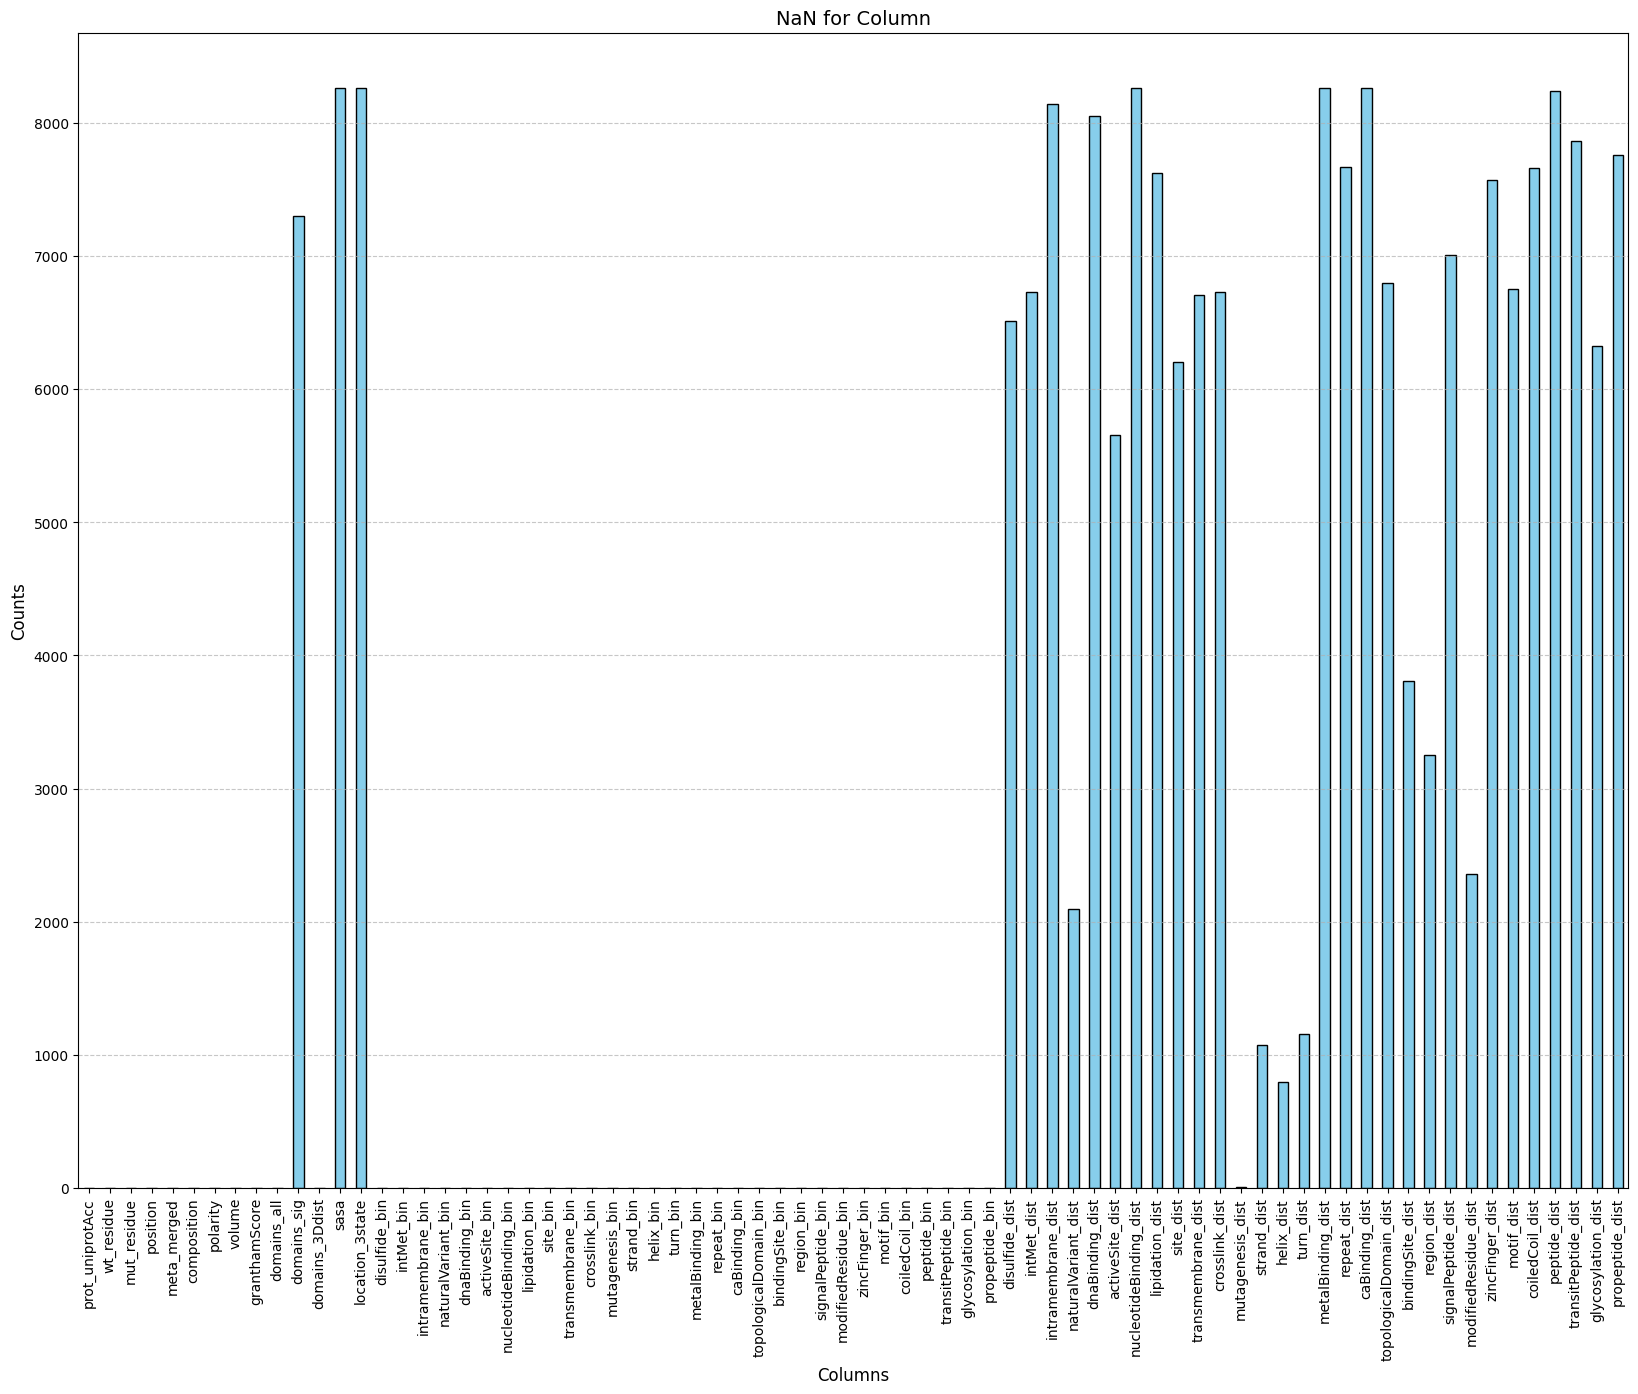

In [49]:
nan_counts = data.isna().sum()

plt.figure(figsize=(20, 15))
nan_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('NaN for Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [50]:
missing_percent = data.isna().mean() * 100
columns_to_remove = missing_percent[missing_percent > 20].index
print(columns_to_remove)

Index(['domains_sig', 'sasa', 'location_3state', 'disulfide_dist',
       'intMet_dist', 'intramembrane_dist', 'naturalVariant_dist',
       'dnaBinding_dist', 'activeSite_dist', 'nucleotideBinding_dist',
       'lipidation_dist', 'site_dist', 'transmembrane_dist', 'crosslink_dist',
       'metalBinding_dist', 'repeat_dist', 'caBinding_dist',
       'topologicalDomain_dist', 'bindingSite_dist', 'region_dist',
       'signalPeptide_dist', 'modifiedResidue_dist', 'zincFinger_dist',
       'motif_dist', 'coiledCoil_dist', 'peptide_dist', 'transitPeptide_dist',
       'glycosylation_dist', 'propeptide_dist'],
      dtype='object')


In [51]:
data['identifier'] = data['prot_uniprotAcc'] + '_' + data['wt_residue'] + '_' + data['position'].astype(str) + '_' + data['mut_residue']
data.set_index('identifier', inplace=True)

In [52]:
data_cleaned = data.drop(columns=columns_to_remove)
data_cleaned = data_cleaned.drop(columns=['domains_all', 'meta_merged', 'prot_uniprotAcc', 'position', 'mut_residue', 'wt_residue'])
data_cleaned.iloc[:, -4:] = data_cleaned.iloc[:, -4:].astype(float)

/tmp/ipykernel_231238/1755094259.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_cleaned.iloc[:, -4:] = data_cleaned.iloc[:, -4:].astype(float)


In [53]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8267 entries, O00299_C_24_S to O75319_R_239_K
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   composition            8267 non-null   float64
 1   polarity               8267 non-null   float64
 2   volume                 8267 non-null   float64
 3   granthamScore          8267 non-null   int64  
 4   domains_3Ddist         8267 non-null   float64
 5   disulfide_bin          8267 non-null   int64  
 6   intMet_bin             8267 non-null   int64  
 7   intramembrane_bin      8267 non-null   int64  
 8   naturalVariant_bin     8267 non-null   int64  
 9   dnaBinding_bin         8267 non-null   int64  
 10  activeSite_bin         8267 non-null   int64  
 11  nucleotideBinding_bin  8267 non-null   int64  
 12  lipidation_bin         8267 non-null   int64  
 13  site_bin               8267 non-null   int64  
 14  transmembrane_bin      8267 non-null   

In [54]:
#data_cleaned.to_csv('dataset_cleaned.csv')

## Train & Test

In [55]:
dataTrain = pd.read_csv('../dataset/data_train.csv', index_col='identifier')
dataTrain

,Unnamed: 0,uniprot_id,wildtype,position,mutation,pdb_id,pdb_pos,phenotypic_annotation,interaction,binding,...,glycosylation,sumoylation,acetylation,other_ptm,methylation,ribosylation,subcell_localization_change,mimetic_ptm,folding,expression
identifier,,,,,,,,,,,,,,,,,,,,,
P31749_K_8_R,0,P31749,K,8,R,1unp:A,8,"Substantial reduction of ubiquitination, phosp...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
P31749_K_14_A,1,P31749,K,14,A,1unp:A,14,"Impairs interaction with PtdIns(3,4,5)P3 and P...",NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P31749_K_14_Q,2,P31749,K,14,Q,1unp:A,14,Substantial reduction of phosphorylation at T-...,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
P31749_K_14_R,3,P31749,K,14,R,1unp:A,14,"Substantial reduction of ubiquitination, phosp...",NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
P31749_E_17_K,4,P31749,E,17,K,1unp:A,17,No effect on membrane localization. Loss of me...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q16665_S_247_D,7995,Q16665,S,247,D,4h6j:A,247,Impaired kinase activity.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q16665_L_795_A,7996,Q16665,L,795,A,1l8c:B,118,Inhibits interaction with EP300 and transactiv...,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q16665_C_800_A,7997,Q16665,C,800,A,1l8c:B,123,Blocks increase in transcriptional activation ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
data_merged = pd.merge(data_cleaned, dataTrain['function'], left_index=True, right_index=True, how='inner')
data_merged.to_csv('additional_features.csv')

In [70]:
# from tqdm import tqdm
# features = []

# for index in tqdm(data_merged.index, desc='Preparing features'):
#     if index + '.pt' in os.listdir('../embedding/graphs'):
#         graph_path = os.path.join('../embedding/graphs', f"{index}.pt")
#         graph = torch.load(graph_path)[0]

#         tmp = from_networkx(graph)

#         features.append(tmp.features)

Preparing features: 100%|██████████| 8267/8267 [2:42:18<00:00,  1.18s/it]  


In [35]:
for cv, split in enumerate(os.listdir('../splits')):
    if split.endswith('.csv'):
        print(f'Cross Validation: Fold {cv}')
        split_data = pd.read_csv(f'{os.path.join("../splits", split)}')
        
        ids_train = list(split_data['train'])
        ids_val = [x for x in list(split_data['val']) if not (isinstance(x, float) and math.isnan(x))]

        filtered_ids_train = [id_ for id_ in ids_train if id_ in data_merged.index]
        filtered_ids_val = [id_ for id_ in ids_val if id_ in data_merged.index]

        outcome_train = data_merged.loc[filtered_ids_train]['function'].tolist()
        outcome_val = data_merged.loc[filtered_ids_val]['function'].tolist()

        outcome_train = [outcome for outcome in outcome_train if outcome != -999]
        outcome_val = [outcome for outcome in outcome_val if outcome != -999]

        ids_train_filtered = [filtered_ids_train[i] for i in range(len(outcome_train)) if outcome_train[i] != -999]
        ids_val_filtered = [filtered_ids_val[i] for i in range(len(outcome_val)) if outcome_val[i] != -999]

        X_train = data_merged.loc[ids_train_filtered].drop('function', axis=1)
        X_val = data_merged.loc[ids_val_filtered].drop('function', axis=1)

        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_val_imputed = imputer.transform(X_val)

        #model = RandomForestClassifier(n_estimators=100, random_state=42)
        model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        
        model.fit(X_train_imputed, outcome_train)

        y_pred = model.predict(X_val_imputed)

        mcc = matthews_corrcoef(outcome_val, y_pred)
        print(f'MCC: {mcc}')

Cross Validation: Fold 0
MCC: 0.08949862803449155
Cross Validation: Fold 1
MCC: -0.03490511659407592
Cross Validation: Fold 2
MCC: -0.023446445815878784
Cross Validation: Fold 3
MCC: -0.013204019077991722
Cross Validation: Fold 4
MCC: -0.026467170250342748


In [44]:
param_grid = {
    'n_estimators': [10, 20, 30, 100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.01],
    'max_depth': [2,3,4,5]
}

mcc_scorer = make_scorer(matthews_corrcoef)

for cv, split in enumerate(os.listdir('../splits')):
    if split.endswith('.csv'):
        print(f'Cross Validation: Fold {cv}')
        split_data = pd.read_csv(f'{os.path.join("../splits", split)}')
        
        ids_train = list(split_data['train'])
        ids_val = [x for x in list(split_data['val']) if not (isinstance(x, float) and math.isnan(x))]

        filtered_ids_train = [id_ for id_ in ids_train if id_ in data_merged.index]
        filtered_ids_val = [id_ for id_ in ids_val if id_ in data_merged.index]

        outcome_train = data_merged.loc[filtered_ids_train]['function'].tolist()
        outcome_val = data_merged.loc[filtered_ids_val]['function'].tolist()

        outcome_train = [outcome for outcome in outcome_train if outcome != -999]
        outcome_val = [outcome for outcome in outcome_val if outcome != -999]

        ids_train_filtered = [filtered_ids_train[i] for i in range(len(outcome_train)) if outcome_train[i] != -999]
        ids_val_filtered = [filtered_ids_val[i] for i in range(len(outcome_val)) if outcome_val[i] != -999]

        X_train = data_merged.loc[ids_train_filtered].drop('function', axis=1)
        X_val = data_merged.loc[ids_val_filtered].drop('function', axis=1)

        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_val_imputed = imputer.transform(X_val)

        pos_class_weight = (len(outcome_train) - np.sum(outcome_train)) / np.sum(outcome_train)

        rf = XGBClassifier(objective='binary:logistic',
                           scale_pos_weight=pos_class_weight,
                           random_state=42)

        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring=mcc_scorer,
            n_jobs=-1
        )

        grid_search.fit(X_train_imputed, outcome_train)

        best_model = grid_search.best_estimator_
        print(f'Best params for Fold {cv}: {grid_search.best_params_}')

        #y_proba = model.predict_proba(X_val_imputed)[:, 1]

        #threshold = 0.6
        #y_pred = (y_proba >= threshold).astype(int)

        y_pred = best_model.predict(X_val_imputed)

        mcc = matthews_corrcoef(outcome_val, y_pred)
        print(f'MCC: {mcc}\n')

Cross Validation: Fold 0


Best params for Fold 0: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
MCC: -0.04513655887497643

Cross Validation: Fold 1
Best params for Fold 1: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
MCC: -0.017576471672866252

Cross Validation: Fold 2
Best params for Fold 2: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
MCC: -0.02340467090591328

Cross Validation: Fold 3
Best params for Fold 3: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
MCC: 0.04188954764831613

Cross Validation: Fold 4
Best params for Fold 4: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10}
MCC: -0.02320671583582982

